In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import dateutil as du
import math
import json
import numpy as np
import re
%matplotlib inline

pd.set_option('display.max_columns', None)

# 1. How has the popularity of different genres changed over the last ~9 years?
  
    
Using the TMDB dataset to create time series data for each genre   



Note tmdb popularity is a measurement very specific to the day the data was copied, so I'll be using vote_average and vote amount

## a) Question specific cleaning:

In [105]:
tmdb = pd.read_csv('clean_data/clean_tmdb.csv')

In [106]:
tmdb.head(2)

,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
1,10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,False,True,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False


In [107]:
tmdb.describe()
tmdb[tmdb.vote_count >= 5].describe()

,id,popularity,vote_average,vote_count
count,13042.000000,13042.000000,13042.000000,13042.000000
mean,254871.893498,5.124739,5.920649,347.796197
std,151505.761470,5.129282,1.226152,1255.116211
min,27.000000,0.600000,0.000000,5.000000
25%,102940.500000,1.716000,5.200000,9.000000
50%,260359.000000,3.267000,6.000000,24.000000
75%,381695.250000,7.118000,6.800000,108.000000
max,589023.000000,80.773000,10.000000,22186.000000


Looking at films with 5 or more votes to lessen the effect of an anomlolous voters' opinions: the vote_average median hasn't changed and the quartiles are both moved in by 0.2, showing the movies with few votes were distributed towards the extremes (though fairly balanced), reinforcing my decision.

In [108]:
tmdb = tmdb[tmdb.vote_count >= 5]

In [109]:

tmdb.release_date = tmdb.release_date.\
                    apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date())

In [110]:
tmdb = tmdb.sort_values(by = ['release_date'])

## b) Data Engineering  
   
   
For seeing how the popularity changes over time I'm going to use the data provided to create time series data: a rolling average with a 6 month window, finding aggregates for a data point every 3 months

In [111]:
begin = dt.date(2008, 1, 1)
data = []
genres = tmdb.iloc[:,8:].columns
#loop through every third month in range:
for m in range(0, 141, 3):
    #create new table with only the films in range
    centre = begin + du.relativedelta.relativedelta(months = m)
    start = centre - du.relativedelta.relativedelta(months = 3)
    end = centre + du.relativedelta.relativedelta(months = 3)
    tmdb_win = tmdb[(tmdb.release_date > start) & (tmdb.release_date <= end)]
    
    gdata = {}
    for g in genres:
        #for each genre get aggregate data of films within window
        num_films = tmdb_win[tmdb_win[g]].vote_average.count()        
        median_vote = tmdb_win[tmdb_win[g]].vote_average.median()
        mean_vote = tmdb_win[tmdb_win[g]].vote_average.median()
        median_vote_count = tmdb_win[tmdb_win[g]].vote_count.mean()
        mean_vote_count = tmdb_win[tmdb_win[g]].vote_count.mean()
        
        #find sum of each film's vote_average weighted by vote_count 
        #...or log(vote_count)
        total_vote_score = 0
        weighted_sum = 0
        for h, d in tmdb_win[tmdb_win[g]].iterrows():
            #for each film find the Total Vote Score add it to the genre's TVS
            # do same for weighted score
            total_vote_score += d.vote_average * d.vote_count
            weighted_sum += d.vote_average * math.log(d.vote_count)
        
        total_vote_score_per_film = round(total_vote_score / num_films, 2)
        weighted_mean = round(weighted_sum / num_films, 2)
        
        #create dict of genre data, add it to dict of genre data for the month
        gdata[g] = {'median_vote':median_vote, 
                    'mean_vote':mean_vote,
                    'median_vote_count':median_vote_count,
                    'mean_vote_count':mean_vote_count,
                    'num_films':num_films,
                    'total_vote_score':total_vote_score,
                    'total_vote_score_per_film':total_vote_score_per_film,
                    'weighted__sum':weighted_sum,
                    'weighted_mean':weighted_mean,
                    'date': begin +du.relativedelta.relativedelta(months = m)
                    }
            
    #add month's genre data to data list
    data.append(gdata)
    
df = pd.DataFrame(data)
df.transpose();

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars


^^Warning^^   
Towards the edges of the timeframe the data peter's out, and I think some genres go down to 0 films, which it then tries to divide by. You'll see below that I slice the unreliable edges off the data ([11:-3]) when visualising.

In [112]:
df.head(2) #As mentioned, some null values at the beginning of the timeframe

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,"{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.4, 'mean_vote': 5.4, 'median...","{'median_vote': 5.3, 'mean_vote': 5.3, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.4, 'mean_vote': 5.4, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.25, 'mean_vote': 5.25, 'medi...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.4, 'mean_vote': 5.4, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median..."
1,"{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.4, 'mean_vote': 5.4, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.35, 'mean_vote': 5.35, 'medi...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': 5.4, 'mean_vote': 5.4, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median...","{'median_vote': nan, 'mean_vote': nan, 'median..."


I end up with a table of genres along the top, months along the side and avery value is a dictionary of the corresponding aggregates. But how to read the data in such a way as to graph it?  

I found that if I select a genre so that I have a single column of dictionaries I could then use **.apply(pd.Series)** to turn each dictionary into a series, producing a table which I could put into seaborn.

In [113]:
df.Animation.apply(pd.Series).head(2) 
#Again, also, some of the aforementioned null values

,median_vote,mean_vote,median_vote_count,mean_vote_count,num_films,total_vote_score,total_vote_score_per_film,weighted__sum,weighted_mean,date
0,NaN,NaN,NaN,NaN,0,0.0,NaN,0.0,NaN,2008-01-01
1,NaN,NaN,NaN,NaN,0,0.0,NaN,0.0,NaN,2008-04-01


In [1]:
df.Animation.apply(pd.Series).columns
# -graphable aggregates

NameError: name 'df' is not defined

In [115]:
sns.set_context('talk')

In [116]:
#Give each genre a number that its colour will be based on, 
#otherwise the colour changes between different genre lists
genre_list =list(zip(list(tmdb.iloc[:,8:].columns),range(17)))

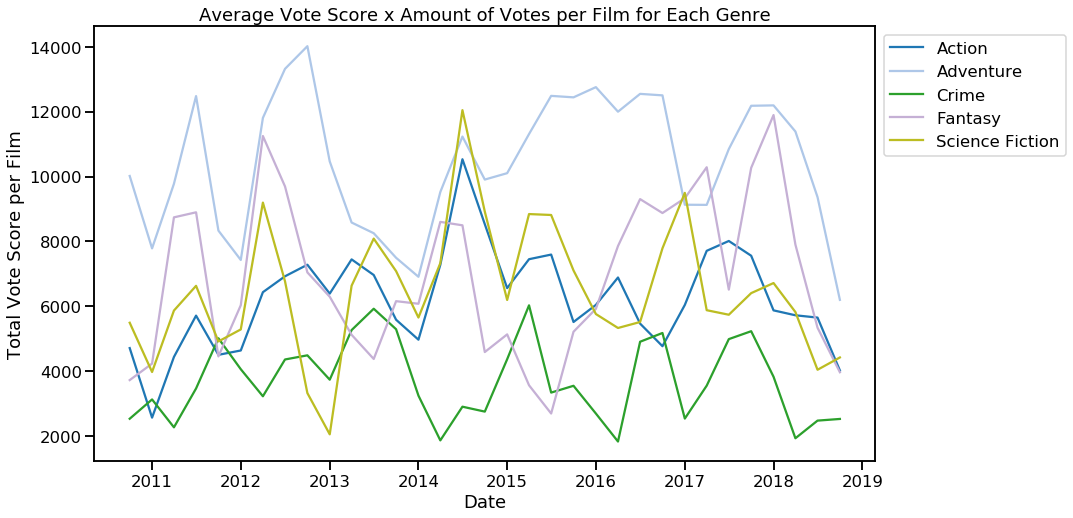

In [117]:
#lists of which genres to visualise
genres_small = [genre_list[i] for i in [0,3,5,6,9,13,16]]
genres_small_2 = [genre_list[i] for i in [0,1,4,8,14]]
genres_all = genre_list
genres = genres_small_2

fig, ax = plt.subplots(figsize=(14,8))
#force each genre to be a different colour:
cm=plt.get_cmap('tab20')
ax.set_prop_cycle(color=[cm(i[1]/len(genre_list)) for i in genres])
#create lineplot for each genre:
for g in genres:
    sns.lineplot(x='date', y='total_vote_score_per_film', 
                 data = df[g[0]].apply(pd.Series)[11:-3], label=g[0])
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set(xlabel='Date', ylabel='Total Vote Score per Film', 
       title = 'Average Vote Score x Amount of Votes per Film for Each Genre');
# plt.savefig('figs/weighted_mean2_fig.png', bbox_inches='tight')

### Results:  

I recommend making a Fantasy-Adventure movie. These genres have shown to be consistently popular. Release is favoured towards summer, of an even year.  

If you want to go high-risk - high-reward, you could try History, War or Western; to make a film that stands out in its genre.    

Whereas if you were looking to garner renown even at the expense of audience size, then you'd want to make documentaries.  
  
Whichever genre you do decide to make, we can use the peaks on these graphs to see when the best time to release it would be.

#### With Extra time:  
Would set each genre to a different colour which it would keep between graphs -currently depends on the genre list.   -fixed   

Would create a dictionary of labels for each graph, and create a loop to draw all of them.  
 
  

# 2. Which two people give the most return when working together?
   
     
     
### Databases:  
**imdb.principles** -to find people who work together   
**imdb.basics** -merge by tconst(the film code); to find the primary title   
**tn.movie_budgets** -join by title; use budget and wwgross to find RoI  
**imdb.names** -join by name code (nconst) to find names  
  
  What you’re about to see:
- Join datasets together, calculate RoI
- Create a dictionary with the pairs of name-codes as keys, and a list of their joint film-codes as values
- Make a dataframe from this, replace film-codes with RoI  
- find 30th percentile of RoI for each pair
- Make the dataframe again but this time replace film-codes with Titles  
- Join these dataframes together
- Add names from the name codes
- Look at the top 100, pick by hand those to drop for only being in franchises
- Visualise


In [118]:
prin = pd.read_csv('clean_data/clean_principles.csv')
bas = pd.read_csv('clean_data/clean_basics.csv')
bud = pd.read_csv('clean_data/clean_movie_budgets.csv')
nam = pd.read_csv('clean_data/clean_names.csv')

Prepare budget database and join it to the basics database to get the budget & gross for each title.

In [119]:
bud.drop(columns = 'Unnamed: 0', inplace = True)

In [120]:
bud.set_index('movie', inplace = True)

In [121]:
basbud = bas.join(bud, on = 'primary_title', how = 'inner')

Merge with principles database using tconst, add RoI column

In [122]:
prinbasbud = prin.merge(basbud, left_on = 'tconst', right_on = 'tconst')

In [123]:
prinbasbud['RoI'] = prinbasbud.apply(lambda x: 
                                     (x.worldwide_gross-x.production_budget)
                                     /x.production_budget, axis=1)

In [124]:
len(prinbasbud.tconst.unique())

3525

In [125]:
films = prinbasbud.tconst.unique()

In the next cell I create a dictionary entry for each pair of people who have worked together, with a list of the films they worked on together.  
To do this:   
- for each film, it loops through the names in that film  
- for each name, it loops through the names in the film that haven't come up yet   
- sorts the names (in case they've come up elsewhere in a different order)
- The names are joined  
- then either the key for the pair is created with a value of the film code, or the film is added to the entry for the pair  
  

#### Warning -takes a while to run
   
Note: joined DBs first to weed out films I wouldn't have data for, to this speed up.

In [126]:
pairs = {}
for f in films:
    for i, n1 in enumerate(prinbasbud[prinbasbud.tconst == f].nconst):
         for n2 in prin[prin.tconst == f].nconst[i+1:]:
            names = [n2,n1]
            names.sort()
            pair = names[0]+'_'+names[1]
            if pairs.get(pair):
                pairs[pair] = pairs[pair] + [f]
            else:
                pairs[pair] = [f]

In [127]:
len(pairs)

121693

In [128]:
# Took a long time to get pairs, so saving it as a json file:
json = json.dumps(pairs)
f = open('name_pairs', 'w')
f.write(json)
f.close()

In [129]:
pairs_c = pairs.copy()

In [130]:
#Select the pairs who have worked together on more than 2 films
multi_pairs ={}
for k, v in pairs_c.items():
    if len(v) > 2:
        multi_pairs[k] = v
len(multi_pairs)

724

In [131]:
len(pairs)

121693

In [132]:
len(multi_pairs)

724

In [133]:
#create a dataframe from the multipairs dict
mp_df = pd.DataFrame.from_dict(multi_pairs, orient = 'index')

In [134]:
mp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
nm0001053_nm0001054,tt0475290,tt1809398,tt2042568,tt1403865,tt3682448,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0079677_nm0271479,tt0475290,tt0947810,tt1213663,tt1524137,tt1092026,tt2328900,tt2194499,tt1781769,tt1340800,tt3787590,tt2980516,tt2719848,tt4085696,tt3569230,tt3569230,tt4555426,tt3890160,tt6811018
nm0717230_nm5473782,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm0717230,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm5473782,tt1083452,tt2066051,tt2802144,tt4649466,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Some of the films are missing budget data, removing these:

In [135]:
prinbasbud.drop(prinbasbud[prinbasbud.RoI==0].index, inplace = True)

In [136]:
prinbasbud.columns

Index(['tconst', 'ordering', 'nconst', 'category', 'characters',
       'primary_title', 'original_title', 'start_year', 'runtime_minutes',
       'genres', 'Action', 'Crime', 'Drama', 'Biography', 'Comedy', 'Fantasy',
       'Horror', 'Thriller', 'Adventure', 'Animation', 'Documentary',
       'History', 'Mystery', 'Sci-Fi', 'Romance', 'Family', 'War', 'Music',
       'Sport', 'Western', 'Musical', 'Adult', 'News', 'Talk-Show',
       'Reality-TV', 'Game-Show', 'Short', 'id', 'release_date',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'RoI'],
      dtype='object')

With mp_df, for each pair I have the codes for the films they've been in together. From here I need to get the RoIs and the titles for each film.

In [137]:
#make a dictionary of the film codes with the corresponding value from the
#...column passed in
def get_insert(col):
    insert = {}
    for f in prinbasbud.iterrows():
        insert[f[1].tconst] = f[1][col]        
    return insert

In [138]:
RoI = get_insert('RoI')

In [139]:
#replace tconst values with RoI values
mp_roi = mp_df.replace(RoI)

In [140]:
mp_roi.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
nm0001053_nm0001054,1.91639,1.51581,1.99484,6.20791,3.06246,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0079677_nm0271479,1.91639,-0.0247698,1.37543,2.93627,1.52905,0.869389,6.44243,0.449074,2.87871,4.07671,7.22185,2.40457,20.8507,0.697018,0.697018,4.02691,5.70895,-0.519518
nm0717230_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm0717230,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm5473782,0.959151,1.64982,3.30385,2.9308,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [141]:
#Remove films without an entry in prinbasbud, replace with NaN
#these films would'nt have been replaced by RoI and are still their tconst value
mp_roi.replace(to_replace = 'tt*', value = np.nan, regex = True, inplace = True)

Find the 30th percentile of each pair's RoI  
- 30th because we want a pair with consistency

In [142]:
mp_roi['p_thirty'] = mp_roi.quantile(q = 0.3, numeric_only = False, axis = 1)

In [143]:
mp_roi.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,p_thirty
nm0001053_nm0001054,1.916395,1.515813,1.994841,6.207912,3.062458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.932084
nm0079677_nm0271479,1.916395,-0.024770,1.375425,2.936274,1.529053,0.869389,6.442431,0.449074,2.878705,4.076708,7.221846,2.40457,20.850749,0.697018,0.697018,4.026906,5.708947,-0.519518,0.919993
nm0717230_nm5473782,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755
nm0092061_nm0717230,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755
nm0092061_nm5473782,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755


In [144]:
title = get_insert('primary_title')

In [145]:
#replace tconst values with titles
mp_title = mp_df.replace(title)

In [146]:
mp_rt = mp_roi.join(mp_title, rsuffix = '_title')

In [147]:
mp_rt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,p_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title
nm0001053_nm0001054,1.916395,1.515813,1.994841,6.207912,3.062458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.932084,"Hail, Caesar!",Unbroken,Inside Llewyn Davis,True Grit,Bridge of Spies,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0079677_nm0271479,1.916395,-0.024770,1.375425,2.936274,1.529053,0.869389,6.442431,0.449074,2.878705,4.076708,7.221846,2.40457,20.850749,0.697018,0.697018,4.026906,5.708947,-0.519518,0.919993,"Hail, Caesar!",Green Zone,The World's End,Contraband,Paul,Mary Queen of Scots,About Time,Anna Karenina,Tinker Tailor Soldier Spy,We Are Your Friends,The Theory of Everything,Everest,Billy Elliot,Legend,Legend,Darkest Hour,Baby Driver,The Kid Who Would Be King
nm0717230_nm5473782,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755,Eddie the Eagle,Rocketman,Kingsman: The Secret Service,Kingsman: The Golden Circle,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm0717230,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755,Eddie the Eagle,Rocketman,Kingsman: The Secret Service,Kingsman: The Golden Circle,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0092061_nm5473782,0.959151,1.649823,3.303848,2.930805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.580755,Eddie the Eagle,Rocketman,Kingsman: The Secret Service,Kingsman: The Golden Circle,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [148]:
#Some films are entered more than once: remove rows without enough unique values
mp_rt = mp_rt[mp_rt.apply(lambda x: x.nunique() > 7, axis = 1)]
# 7 is 3 unique RoIs, 1 p_thirty, 3 unique titles

In [149]:
mp_rt.sort_values(by = 'p_thirty', ascending = False, inplace = True)

In [150]:
mp_rt.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,p_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title
nm1177766_nm1490123,65.580591,38.517372,15.788559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.425847,Insidious,Annabelle,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0484907_nm2305431,27.563598,40.407969,58.170677,17.180971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.525336,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm2124081_nm2305431,40.407969,-0.998489,65.580591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0089658_nm2124081,40.407969,-0.998489,65.580591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
nm0089658_nm0484907,27.563598,40.407969,58.170677,17.180971,24.002052,6.131055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.591511,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,Happy Death Day,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None


In [151]:
len(mp_rt)

536

In [152]:
#Now we want to add the pairs' names and, just in case, professions
#helper functions for apply:
def find_name(ncode):
    return nam[nam.nconst == ncode].primary_name.item()
def find_profession(ncode):
    return nam[nam.nconst == ncode].primary_profession.item()

In [153]:
mp_rt = mp_rt.reset_index().rename(columns = {'index': 'pair'})

In [154]:
mp_rt['name_one'] = mp_rt.pair.apply(lambda x: find_name(x.split('_')[0]))
mp_rt['name_two'] = mp_rt.pair.apply(lambda x: find_name(x.split('_')[1]))

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [155]:
mp_rt['profession_one'] = mp_rt.pair.apply(lambda x: find_profession(x.split('_')[0]))
mp_rt['profession_two'] = mp_rt.pair.apply(lambda x: find_profession(x.split('_')[1]))

C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [156]:
#Let's look at top 100, and for the results we don't need the individual RoIs 
mp_rt_results = mp_rt.iloc[:,19:].head(100)
mp_rt_results.head()

,p_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title,name_one,name_two,profession_one,profession_two
0,29.425847,Insidious,Annabelle,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Joseph Bishara,James Wan,"composer,music_department,actor","producer,writer,director"
1,26.525336,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Christopher Landon,Oren Peli,"writer,producer,director","producer,writer,director"
2,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Steven Schneider,Oren Peli,"producer,writer","producer,writer,director"
3,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Steven Schneider,"producer,executive,actor","producer,writer"
4,20.591511,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,Happy Death Day,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Christopher Landon,"producer,executive,actor","writer,producer,director"


In [157]:
#drop rows where there are no more than 2 films from different franchises as 
#...this doesn't show that it's the people working together, just that the 
#...franchises made money, looking through, picked by hand:
mp_rt_results = mp_rt_results.drop([0,1,4,5,6,8,9,10,12,13,14,15,16,17,18,19,20,
                                    21,22,23,25,26,27,28,29,30,33,34,35,36,37,38,39,40,43,45,46,47,48,49,50,51,52,
                    53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71,72,73,74,
                    75,76,77,78,79,80,81,82,83,84,85,86,88,89,90,91,92,93,94,95,96,
                    97,98,99])

In [158]:
mp_rt_results = mp_rt_results.reset_index().drop(columns = 'index')

In [159]:
mp_rt_results

,p_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title,name_one,name_two,profession_one,profession_two
0,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Steven Schneider,Oren Peli,"producer,writer","producer,writer,director"
1,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Steven Schneider,"producer,executive,actor","producer,writer"
2,15.927800,Paranormal Activity 4,Paranormal Activity 3,Area 51,Paranormal Activity 2,Insidious,The Lords of Salem,Paranormal Activity: The Marked Ones,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,Jason Blum,Oren Peli,"producer,executive,actor","producer,writer,director"
3,14.822808,Get Out,Happy Death Day,Insidious: The Last Key,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Toby Oliver,Jason Blum,"cinematographer,camera_department,producer","producer,executive,actor"
4,11.067989,The Purge,Ouija,A Nightmare on Elm Street,A Nightmare on Elm Street,Project Almanac,The Purge: Anarchy,The Purge: Election Year,A Quiet Place,The First Purge,None,None,None,None,None,None,None,None,None,Michael Bay,Andrew Form,"producer,director,actor","producer,miscellaneous,costume_department"
5,10.582983,The Purge,Ouija,Project Almanac,The Purge: Anarchy,The Purge: Election Year,A Quiet Place,The First Purge,None,None,None,None,None,None,None,None,None,None,None,Andrew Form,Brad Fuller,"producer,miscellaneous,costume_department","producer,executive"
6,10.582983,The Purge,Ouija,Project Almanac,The Purge: Anarchy,The Purge: Election Year,A Quiet Place,The First Purge,None,None,None,None,None,None,None,None,None,None,None,Michael Bay,Brad Fuller,"producer,director,actor","producer,executive"
7,7.665707,Despicable Me 2,Hop,Despicable Me,Despicable Me 3,The Secret Life of Pets,None,None,None,None,None,None,None,None,None,None,None,None,None,Ken Daurio,Cinco Paul,"writer,director,producer","writer,producer,actor"
8,7.379297,Seven Psychopaths,The Best Exotic Marigold Hotel,The Second Best Exotic Marigold Hotel,"Three Billboards Outside Ebbing, Missouri",None,None,None,None,None,None,None,None,None,None,None,None,None,None,Graham Broadbent,Peter Czernin,producer,"producer,actor,miscellaneous"
9,6.755147,Despicable Me 2,Minions,Sing,The Secret Life of Pets 2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Janet Healy,Christopher Meledandri,"producer,visual_effects,miscellaneous","producer,miscellaneous,executive"


In [160]:
#No. of films (or franchises) they were in together
mp_rt_results['num'] = [3, 3, 4, 3, 5, 4, 4, 3, 3, 4, 3, 3, 3]

In [161]:
#Let's see the results again, this time focusing on franchises 
mp_rt_results_f = mp_rt.iloc[:,19:].head(100)
mp_rt_results_f.head(50)

,p_thirty,0_title,1_title,2_title,3_title,4_title,5_title,6_title,7_title,8_title,9_title,10_title,11_title,12_title,13_title,14_title,15_title,16_title,17_title,name_one,name_two,profession_one,profession_two
0,29.425847,Insidious,Annabelle,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Joseph Bishara,James Wan,"composer,music_department,actor","producer,writer,director"
1,26.525336,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Christopher Landon,Oren Peli,"writer,producer,director","producer,writer,director"
2,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Steven Schneider,Oren Peli,"producer,writer","producer,writer,director"
3,23.845386,Paranormal Activity 3,Area 51,Insidious,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Steven Schneider,"producer,executive,actor","producer,writer"
4,20.591511,Paranormal Activity 4,Paranormal Activity 3,Paranormal Activity 2,Paranormal Activity: The Marked Ones,Happy Death Day,Happy Death Day 2U,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,Christopher Landon,"producer,executive,actor","writer,producer,director"
5,17.575397,The Conjuring,Annabelle,Annabelle: Creation,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Peter Safran,James Wan,"producer,manager","producer,writer,director"
6,17.551205,Paranormal Activity 4,Paranormal Activity 3,Nerve,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Henry Joost,Ariel Schulman,"writer,producer,director","writer,producer,director"
7,15.927800,Paranormal Activity 4,Paranormal Activity 3,Area 51,Paranormal Activity 2,Insidious,The Lords of Salem,Paranormal Activity: The Marked Ones,Insidious: The Last Key,None,None,None,None,None,None,None,None,None,None,Jason Blum,Oren Peli,"producer,executive,actor","producer,writer,director"
8,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Marc Bienstock,M. Night Shyamalan,"producer,production_manager,director","producer,writer,director"
9,15.747408,The Visit,Split,Glass,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Jason Blum,M. Night Shyamalan,"producer,executive,actor","producer,writer,director"


Looking for the pairs: if they are only in one or two films, or franchises, together then it could be the films carrying them. So I dropped those pairs from the results that only happened to be in the same franchise together.   
However, though I may not have the statistics for each full franchise, I feel I must mention them. Some of the most profitable franchises are   
From Horror:   
- Insidious  
- Paranormal Activity   
- Annabelle  

Then there's M. Night Shyamalan's   
- Unbreakable/Split/Glass    

Before the more family friendly  
- Despicable Me     

We then leave family friendly far behind again with 
-  The Purge   
- Fifty Shades

In [162]:
mp_rt_results['pair'] = mp_rt_results.apply(lambda x: x.name_one+'_'+x.name_two, axis = 1)

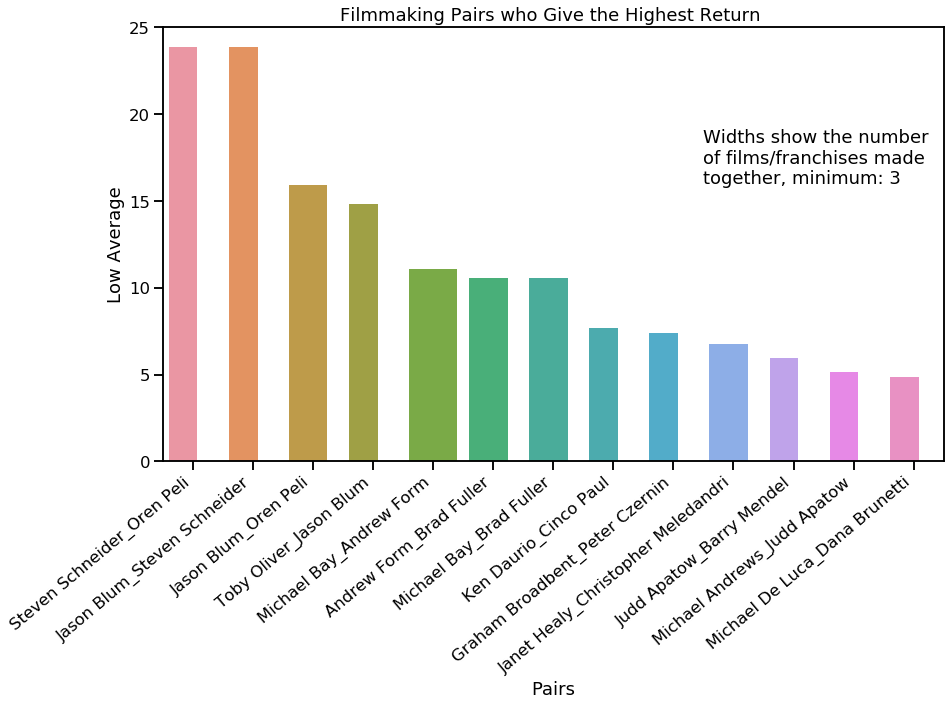

In [163]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(ax=ax, x='pair', y='p_thirty', data=mp_rt_results)
sns.set_context(context='talk')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set(xlabel='Pairs', ylabel='Low Average',
       title='Filmmaking Pairs who Give the Highest Return ')
#make the bar widths vary according to the number of films made together:
widths = mp_rt_results.num.tolist()
for i, patch in enumerate(ax.patches):
    current_width = patch.get_width()
    patch.set_width(current_width*widths[i]/5)
    
ax.text(8.5, 16, 'Widths show the number \nof films/franchises made \ntogether, minimum: 3')
plt.show;
plt.savefig('figs/pairs_fig.png')

### Results  
We have a couple trios, both in the horror sphere:
- Steven Schneider, Oren Peli, Jason Blum; 
- Michael Bay, Andrew Form, Brad Fuller;       
   
   
On one hand the first trio have a higher 30th percentile; on the other, the second trio have worked together on more films and so are less of a gamble.  
   
   
If you want something a bit more family friendly there's   
- Janet Healy & Christopher Meledandri